<a href="https://colab.research.google.com/github/Atom-101/PokeGAN/blob/master/Colab/PokeGAN_Final_32to34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22298 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

import os

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

import os
from random import shuffle
import glob
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [0]:
def show_images(images):

  image = images[0]
  image += 1
  image /= 2.0
  #image = np.ceil(image)
  
  plt.axis('off')
  plt.imshow(image)

#Load

In [6]:
dat = h5py.File('drive/Pokemon/Dataset/HDF5/Pokemon_Fire_Dataset.h5', 'r')
img_array = dat['Pokemon']

print(img_array.shape)

img_array = np.asarray(img_array, dtype = np.float16)

(37962, 96, 96, 3)


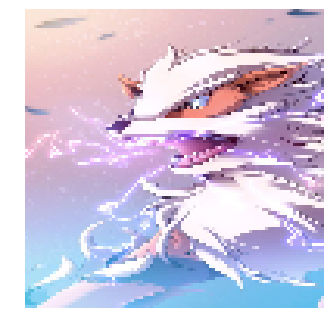

In [0]:
show_images(np.asarray(img_array[3119:3200], dtype = np.float32))
plt.show()

#Discriminator

In [0]:
def discriminator(x,isTrain,keep_prob):
  
    with tf.variable_scope("discriminator"):
        
        
        print(x.shape)
        #print([-1,tf.sqrt(tf.cast(x.shape[1],tf.float32)),tf.sqrt(tf.cast(x.shape[1],tf.float32)),1])
        #x = tf.reshape(x,[-1,(int)((int)(x.shape[1])**.5),(int)((int)(x.shape[1])**.5),1])
        
        x = tf.reshape(x,[-1,96,96,3])
        
        print(x.shape)
        
        logits = tf.layers.conv2d(x,128,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.conv2d(logits,256,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.conv2d(logits,512,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.conv2d(logits,1024,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.flatten(logits)
        
        logits = tf.layers.dense(logits, 1, name = 'discriminator_out', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        
        return logits


# Generator

In [0]:
def generator(z,isTrain,keep_prob):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        
        #print(z.shape)     
        
        img = tf.layers.dense(z, 6*6*1024, activation = tf.nn.leaky_relu, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        img = tf.layers.batch_normalization(img, training = isTrain)
        '''
        img = tf.layers.dense(img, 32*16*16, activation = tf.nn.relu, kernel_initializer=tf.random_normal_initializer(dtype=tf.float16) )
        img = tf.layers.batch_normalization(img, training = isTrain)
        '''
        img = tf.reshape(img,[-1,6,6,1024])
        
        img = tf.layers.conv2d_transpose(img, 512, 3, strides = 2, activation = tf.nn.leaky_relu, padding ='same', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        #img = tf.nn.dropout(img, keep_prob=keep_prob)
        img = tf.layers.batch_normalization(img, training = isTrain)
        
        img = tf.layers.conv2d_transpose(img, 256, 3, strides = 2, activation = tf.nn.leaky_relu, padding ='same', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        #img = tf.nn.dropout(img, keep_prob=keep_prob)
        img = tf.layers.batch_normalization(img, training = isTrain)
        
        img = tf.layers.conv2d_transpose(img, 128, 3, strides = 2, activation = tf.nn.leaky_relu, padding ='same', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        #img = tf.nn.dropout(img, keep_prob=keep_prob)
        img = tf.layers.batch_normalization(img, training = isTrain)
        
        img = tf.layers.conv2d_transpose(img, 3, 3, strides = 2, padding ='same', name = 'generator_out', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        img = tf.nn.tanh(img)
        
        print(img.shape)
        
        #img  = tf.layers.flatten(img)
        
        pass
        return img

In [0]:
def get_solvers(learning_rate=1e-4, beta1=0, beta2=0.9):

    D_solver = None
    G_solver = None
    
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1, beta2=beta2, name = 'D_solver_adam')
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1, beta2=beta2, name = 'G_solver_adam')
    
    pass
    return D_solver, G_solver

In [0]:
def wgan_loss(logits_real, logits_fake, real_data, fake_data,keep_prob,isTrain, batch_size = 32):

  lambd = 10
  G_loss = -tf.reduce_mean(logits_fake)
  D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real) 
  
  #Implement gradient penalty
  epsilon = tf.random_uniform([batch_size,1,1,1], minval = 0, maxval = 1)
  #interpolates = tf.multiply((1-epsilon),real_data)+tf.multiply(epsilon,fake_data) #introduce randomness using epsilon
  interpolates = (1-epsilon)*real_data + epsilon* fake_data
  with tf.variable_scope('', reuse =True):
      grads = tf.gradients(discriminator(interpolates,isTrain,keep_prob), [interpolates])[0] #why is this zero used?
  
  slopes = tf.sqrt(tf.reduce_sum(tf.square(grads))) #L2-norm
  grad_penalty = tf.reduce_mean((slopes-1.)**2)#penalty is a scalar
  
  D_loss += lambd*grad_penalty
    
  pass
  return D_loss, G_loss

In [11]:
tf.reset_default_graph()

batch_size = 32
# our noise dimension
noise_dim = 100

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 96, 96, 3])
isTrain = tf.placeholder(tf.bool, shape=(), name = 'isTrain')
keep_prob = tf.placeholder_with_default(1.0, shape=())

z = tf.random_uniform([batch_size,noise_dim],minval = -1, maxval = 1)
# generated images

G_sample = generator(z,isTrain,keep_prob)

#Variable to store D_loss of each epoch
d_losses = []

#Run when D_loss and G_loss are called
with tf.variable_scope("") as scope:
    logits_real = discriminator(x,isTrain,keep_prob)
    fake_data = G_sample
    scope.reuse_variables()
    logits_fake = discriminator(fake_data,isTrain,keep_prob)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 


D_solver,G_solver = get_solvers()
D_loss, G_loss = wgan_loss(logits_real, logits_fake, x, fake_data,keep_prob,isTrain, batch_size = batch_size)




#Update extra variables like batch_norm gamma and beta
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with tf.control_dependencies(D_extra_step):
  D_train_step = D_solver.minimize(D_loss, var_list=D_vars)

with tf.control_dependencies(G_extra_step):
  G_train_step = G_solver.minimize(G_loss, var_list=G_vars)


(32, 96, 96, 3)
(?, 96, 96, 3)
(?, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


In [0]:
def minibatches(inputs, batchsize):
    indices = np.arange(inputs.shape[0])
    np.random.shuffle(indices)
    x = []
    for i in range(batchsize):
        x.append(inputs[indices[i]])
    return np.asarray(x)

In [0]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, saver,
                     show_every=20, print_every=1, batch_size=32, num_epoch=10):
   
   
    for epoch in range(33599,33599+num_epoch):
        prob = 1 - 0.4**epoch #ranges from 0.6 to 1
        #X = minibatches(img_array,batch_size)
        # every so often, show a sample result
        if (epoch % show_every == 0):
            samples = sess.run(G_sample, feed_dict={isTrain:False})
            fig = show_images(samples[:4])
            plt.show()
            #Save image samples generated while training
            
            print()
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={isTrain:True,keep_prob:prob})
           
        #Train critic 5 times per epoch
        for _ in range(5):
          X = minibatches(img_array,batch_size)
          _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: X, isTrain:True,keep_prob:prob})
          

        #Various displays
        if (epoch % print_every == 0):
            print('Epoch: {}, D: {:.4}, G: {:.4}'.format(epoch,D_loss_curr,G_loss_curr))
        
        #Save stuff every 400 epochs
        if (epoch % 400 == 399):    
          try: 
            saver.save(sess, 'drive/Pokemon_Fire/Final_Checkpoints/Model_'+str(epoch)+'.ckpt')
            np.save('drive/Pokemon_Fire/Final_Discriminator_loss.npy', np.asarray(d_losses))
          except:
            pass
          
          
        d_losses.append(D_loss_curr)
          
        if(epoch%500 == 0):  
          try:
            if(epoch>=1000):
                 with h5py.File('drive/Pokemon_Fire/Final_gen_while_training.h5','a') as file:
                     file.create_dataset('Samples'+str(epoch),samples.shape, np.float32)
                     file['Samples'+str(epoch)][...] = np.asarray(samples, dtype = np.float32)
          except:
            pass

    
    saver.save(sess, 'drive/Pokemon_Fire/Final_Checkpoint_Complete/model.ckpt')
    
    print('Final images')
    samples = sess.run(G_sample, feed_dict={isTrain:False})
    fig = show_images(samples1[:4])
    plt.show()

drive/Pokemon_Fire/Final_Checkpoints/Model_33599.ckpt
INFO:tensorflow:Restoring parameters from drive/Pokemon_Fire/Final_Checkpoints/Model_33599.ckpt
Restored!
Epoch: 33599, D: -6.052, G: 2.185


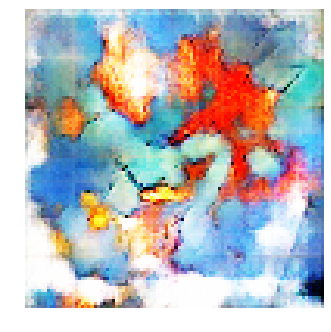


Epoch: 33600, D: -6.179, G: 3.078
Epoch: 33601, D: -6.69, G: 3.956
Epoch: 33602, D: -6.443, G: 3.917
Epoch: 33603, D: -6.15, G: 3.333
Epoch: 33604, D: -5.655, G: 3.819
Epoch: 33605, D: -6.116, G: 0.6191
Epoch: 33606, D: -6.498, G: 2.894
Epoch: 33607, D: -6.775, G: 3.149
Epoch: 33608, D: -7.307, G: 2.448
Epoch: 33609, D: -6.697, G: 3.79
Epoch: 33610, D: -7.308, G: 5.728
Epoch: 33611, D: -5.916, G: 4.859
Epoch: 33612, D: -4.779, G: 4.242
Epoch: 33613, D: -5.963, G: 5.847
Epoch: 33614, D: -5.75, G: 3.292
Epoch: 33615, D: -5.399, G: 5.361
Epoch: 33616, D: -6.459, G: 4.785
Epoch: 33617, D: -6.678, G: 4.708
Epoch: 33618, D: -6.339, G: 3.228
Epoch: 33619, D: -7.342, G: 3.182


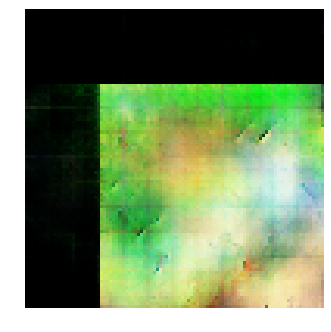


Epoch: 33620, D: -5.481, G: 4.817
Epoch: 33621, D: -5.388, G: 3.787
Epoch: 33622, D: -6.398, G: 3.975
Epoch: 33623, D: -6.327, G: 2.935
Epoch: 33624, D: -7.266, G: 3.25
Epoch: 33625, D: -5.265, G: 2.582
Epoch: 33626, D: -5.809, G: 4.585
Epoch: 33627, D: -6.026, G: 4.756
Epoch: 33628, D: -7.19, G: 3.105
Epoch: 33629, D: -7.277, G: 3.155
Epoch: 33630, D: -5.065, G: 3.731
Epoch: 33631, D: -6.893, G: 4.11
Epoch: 33632, D: -5.786, G: 4.926
Epoch: 33633, D: -6.075, G: 3.315
Epoch: 33634, D: -5.156, G: 4.346
Epoch: 33635, D: -5.814, G: 3.353
Epoch: 33636, D: -5.716, G: 4.351
Epoch: 33637, D: -5.318, G: 4.551
Epoch: 33638, D: -6.537, G: 5.215
Epoch: 33639, D: -5.554, G: 2.627


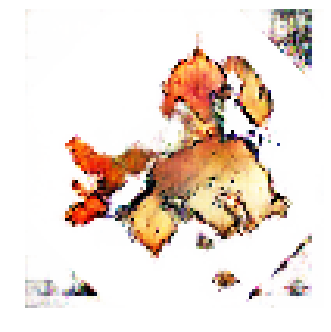


Epoch: 33640, D: -5.44, G: 3.327
Epoch: 33641, D: -6.246, G: 3.403
Epoch: 33642, D: -6.411, G: 4.026
Epoch: 33643, D: -6.05, G: 5.4
Epoch: 33644, D: -6.253, G: 3.889
Epoch: 33645, D: -5.63, G: 4.011
Epoch: 33646, D: -5.397, G: 4.828
Epoch: 33647, D: -5.584, G: 3.434
Epoch: 33648, D: -5.723, G: 3.614
Epoch: 33649, D: -5.782, G: 4.257
Epoch: 33650, D: -6.775, G: 3.852
Epoch: 33651, D: -5.568, G: 4.531
Epoch: 33652, D: -6.389, G: 1.521
Epoch: 33653, D: -7.272, G: 4.466
Epoch: 33654, D: -5.439, G: 3.61
Epoch: 33655, D: -5.132, G: 4.648
Epoch: 33656, D: -3.693, G: 3.833
Epoch: 33657, D: -7.088, G: 3.543
Epoch: 33658, D: -5.694, G: 2.878
Epoch: 33659, D: -5.18, G: 4.197


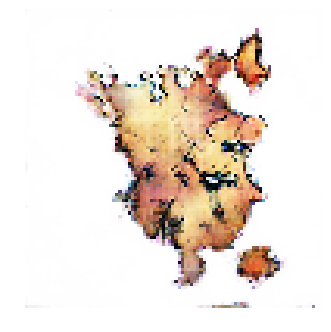


Epoch: 33660, D: -6.011, G: 4.049
Epoch: 33661, D: -7.041, G: 3.588
Epoch: 33662, D: -6.434, G: 5.168
Epoch: 33663, D: -6.577, G: 3.688
Epoch: 33664, D: -6.256, G: 4.121
Epoch: 33665, D: -5.494, G: 3.977
Epoch: 33666, D: -5.731, G: 3.64
Epoch: 33667, D: -4.808, G: 3.361
Epoch: 33668, D: -6.109, G: 5.292
Epoch: 33669, D: -6.748, G: 4.677
Epoch: 33670, D: -6.648, G: 4.16
Epoch: 33671, D: -6.419, G: 1.571
Epoch: 33672, D: -5.093, G: 3.733
Epoch: 33673, D: -3.718, G: 5.309
Epoch: 33674, D: -5.586, G: 4.019
Epoch: 33675, D: -5.883, G: 3.578
Epoch: 33676, D: -5.394, G: 5.731
Epoch: 33677, D: -5.613, G: 4.022
Epoch: 33678, D: -6.47, G: 1.078
Epoch: 33679, D: -7.708, G: 4.764


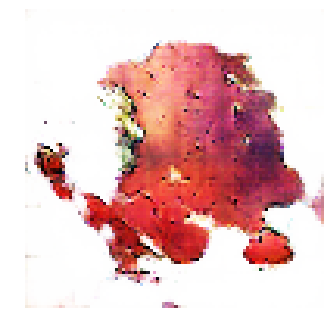


Epoch: 33680, D: -5.738, G: 2.815
Epoch: 33681, D: -6.812, G: 4.75
Epoch: 33682, D: -6.227, G: 3.586
Epoch: 33683, D: -6.55, G: 3.612
Epoch: 33684, D: -7.064, G: 3.941
Epoch: 33685, D: -6.775, G: 5.119
Epoch: 33686, D: -6.812, G: 4.654
Epoch: 33687, D: -6.671, G: 3.087
Epoch: 33688, D: -5.509, G: 4.078
Epoch: 33689, D: -6.16, G: 4.255
Epoch: 33690, D: -4.953, G: 4.099
Epoch: 33691, D: -6.346, G: 2.908
Epoch: 33692, D: -7.086, G: 1.043
Epoch: 33693, D: -5.167, G: 3.263
Epoch: 33694, D: -6.678, G: 3.434
Epoch: 33695, D: -6.836, G: 3.975
Epoch: 33696, D: -6.128, G: 3.498
Epoch: 33697, D: -6.596, G: 4.694
Epoch: 33698, D: -6.585, G: 1.787
Epoch: 33699, D: -5.838, G: 3.174


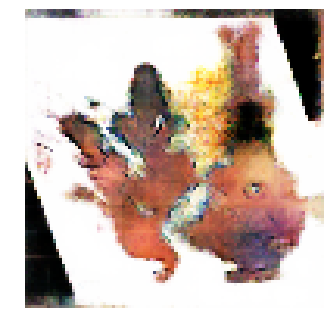


Epoch: 33700, D: -6.325, G: 2.923
Epoch: 33701, D: -7.201, G: 3.27
Epoch: 33702, D: -6.283, G: 4.576
Epoch: 33703, D: -5.722, G: 2.652
Epoch: 33704, D: -4.988, G: 3.857
Epoch: 33705, D: -6.28, G: 3.108
Epoch: 33706, D: -6.991, G: 5.016
Epoch: 33707, D: -5.396, G: 4.027
Epoch: 33708, D: -6.266, G: 4.352
Epoch: 33709, D: -7.114, G: 3.297
Epoch: 33710, D: -4.62, G: 3.314
Epoch: 33711, D: -6.452, G: 4.422
Epoch: 33712, D: -5.748, G: 2.925
Epoch: 33713, D: -7.051, G: 1.375
Epoch: 33714, D: -7.528, G: 3.468
Epoch: 33715, D: -7.426, G: 2.895
Epoch: 33716, D: -7.013, G: 3.674
Epoch: 33717, D: -5.636, G: 4.747
Epoch: 33718, D: -5.688, G: 3.809
Epoch: 33719, D: -5.374, G: 3.563


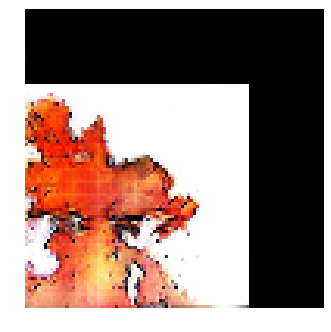


Epoch: 33720, D: -5.563, G: 3.545
Epoch: 33721, D: -4.842, G: 3.873
Epoch: 33722, D: -6.19, G: 5.576
Epoch: 33723, D: -6.337, G: 3.068
Epoch: 33724, D: -5.905, G: 4.91
Epoch: 33725, D: -5.792, G: 3.952
Epoch: 33726, D: -6.435, G: 3.779
Epoch: 33727, D: -5.611, G: 3.93
Epoch: 33728, D: -5.514, G: 3.48
Epoch: 33729, D: -6.514, G: 2.963
Epoch: 33730, D: -5.408, G: 0.9959
Epoch: 33731, D: -4.75, G: 3.816
Epoch: 33732, D: -5.71, G: 2.593
Epoch: 33733, D: -5.778, G: 2.642
Epoch: 33734, D: -5.819, G: 3.761
Epoch: 33735, D: -6.483, G: 3.188
Epoch: 33736, D: -5.814, G: 1.321
Epoch: 33737, D: -6.066, G: 4.85
Epoch: 33738, D: -5.583, G: 3.544
Epoch: 33739, D: -7.048, G: 3.428


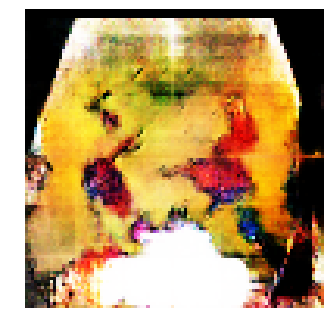


Epoch: 33740, D: -5.682, G: 4.403
Epoch: 33741, D: -4.353, G: 3.033
Epoch: 33742, D: -6.111, G: 3.912
Epoch: 33743, D: -6.324, G: 3.068
Epoch: 33744, D: -7.262, G: 3.948
Epoch: 33745, D: -6.057, G: 4.224
Epoch: 33746, D: -5.469, G: 3.492
Epoch: 33747, D: -5.72, G: 2.756
Epoch: 33748, D: -5.753, G: 2.434
Epoch: 33749, D: -8.372, G: 3.039
Epoch: 33750, D: -4.954, G: 5.09
Epoch: 33751, D: -6.607, G: 4.477
Epoch: 33752, D: -5.502, G: 4.458
Epoch: 33753, D: -4.876, G: 3.397
Epoch: 33754, D: -5.518, G: 3.495
Epoch: 33755, D: -5.793, G: 2.782
Epoch: 33756, D: -6.252, G: 2.723
Epoch: 33757, D: -6.385, G: 3.32
Epoch: 33758, D: -6.427, G: 4.949
Epoch: 33759, D: -6.084, G: 4.74


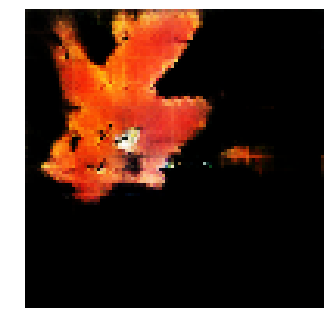


Epoch: 33760, D: -6.349, G: 3.968
Epoch: 33761, D: -6.527, G: 3.458
Epoch: 33762, D: -5.762, G: 3.207
Epoch: 33763, D: -7.822, G: 4.549
Epoch: 33764, D: -6.017, G: 4.203
Epoch: 33765, D: -7.433, G: 3.847
Epoch: 33766, D: -6.189, G: 4.449
Epoch: 33767, D: -5.937, G: 4.82
Epoch: 33768, D: -5.443, G: 3.895
Epoch: 33769, D: -4.751, G: 5.713
Epoch: 33770, D: -5.956, G: 2.925
Epoch: 33771, D: -4.655, G: 3.553
Epoch: 33772, D: -5.606, G: 4.567
Epoch: 33773, D: -5.95, G: 4.414
Epoch: 33774, D: -6.278, G: 2.833
Epoch: 33775, D: -8.126, G: 4.526
Epoch: 33776, D: -6.075, G: 4.155
Epoch: 33777, D: -6.171, G: 3.888
Epoch: 33778, D: -7.53, G: 3.719
Epoch: 33779, D: -5.654, G: 4.107


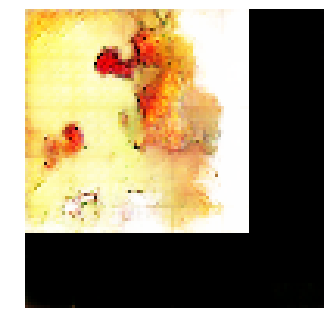


Epoch: 33780, D: -4.132, G: 4.907
Epoch: 33781, D: -5.25, G: 3.355
Epoch: 33782, D: -6.315, G: 3.02
Epoch: 33783, D: -6.435, G: 3.616
Epoch: 33784, D: -5.996, G: 5.592
Epoch: 33785, D: -4.554, G: 3.608
Epoch: 33786, D: -6.393, G: 4.047
Epoch: 33787, D: -5.687, G: 3.621
Epoch: 33788, D: -6.658, G: 3.504
Epoch: 33789, D: -5.549, G: 3.695
Epoch: 33790, D: -7.102, G: 4.814
Epoch: 33791, D: -5.389, G: 3.191
Epoch: 33792, D: -5.832, G: 4.319
Epoch: 33793, D: -5.839, G: 3.871
Epoch: 33794, D: -5.829, G: 3.553
Epoch: 33795, D: -5.647, G: 4.29
Epoch: 33796, D: -5.957, G: 3.64
Epoch: 33797, D: -5.943, G: 2.886
Epoch: 33798, D: -7.229, G: 5.275
Epoch: 33799, D: -5.492, G: 2.61


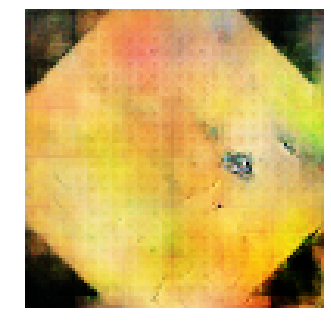


Epoch: 33800, D: -6.389, G: 4.835
Epoch: 33801, D: -8.44, G: 3.253
Epoch: 33802, D: -7.125, G: 4.143
Epoch: 33803, D: -4.97, G: 4.767
Epoch: 33804, D: -6.139, G: 3.347
Epoch: 33805, D: -5.425, G: 3.445
Epoch: 33806, D: -6.028, G: 4.144
Epoch: 33807, D: -5.958, G: 3.369
Epoch: 33808, D: -5.853, G: 2.429
Epoch: 33809, D: -4.826, G: 2.083
Epoch: 33810, D: -4.83, G: 4.052
Epoch: 33811, D: -8.058, G: 5.477
Epoch: 33812, D: -5.833, G: 4.164
Epoch: 33813, D: -5.374, G: 5.597
Epoch: 33814, D: -4.591, G: 5.589
Epoch: 33815, D: -6.943, G: 6.103
Epoch: 33816, D: -6.289, G: 4.175
Epoch: 33817, D: -6.378, G: 4.102
Epoch: 33818, D: -6.65, G: 4.913
Epoch: 33819, D: -6.306, G: 3.253


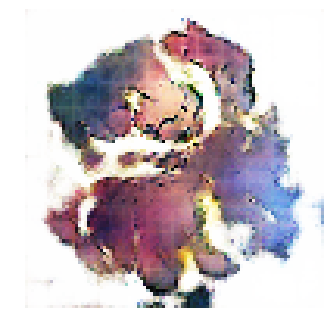


Epoch: 33820, D: -5.421, G: 4.297
Epoch: 33821, D: -7.273, G: 2.539
Epoch: 33822, D: -6.405, G: 4.01
Epoch: 33823, D: -5.771, G: 4.373
Epoch: 33824, D: -6.74, G: 3.185
Epoch: 33825, D: -6.271, G: 6.488
Epoch: 33826, D: -7.539, G: 2.196
Epoch: 33827, D: -6.364, G: 4.014
Epoch: 33828, D: -6.628, G: 4.031
Epoch: 33829, D: -6.408, G: 4.044
Epoch: 33830, D: -5.928, G: 3.684
Epoch: 33831, D: -6.114, G: 5.179
Epoch: 33832, D: -6.807, G: 4.481
Epoch: 33833, D: -6.092, G: 5.074
Epoch: 33834, D: -6.612, G: 5.043
Epoch: 33835, D: -8.561, G: 4.047
Epoch: 33836, D: -5.944, G: 4.727
Epoch: 33837, D: -6.824, G: 4.449
Epoch: 33838, D: -6.777, G: 5.642
Epoch: 33839, D: -6.599, G: 3.821


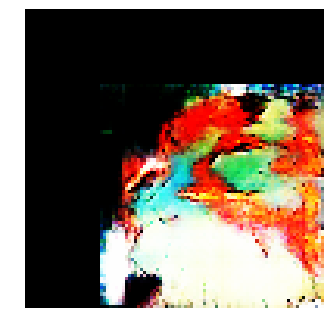


Epoch: 33840, D: -7.629, G: 5.178
Epoch: 33841, D: -5.768, G: 2.981
Epoch: 33842, D: -5.978, G: 4.763
Epoch: 33843, D: -5.649, G: 2.965
Epoch: 33844, D: -5.429, G: 1.659
Epoch: 33845, D: -4.991, G: 4.053
Epoch: 33846, D: -6.223, G: 2.649
Epoch: 33847, D: -6.578, G: 4.335
Epoch: 33848, D: -6.934, G: 3.712
Epoch: 33849, D: -5.679, G: 2.792
Epoch: 33850, D: -5.765, G: 3.162
Epoch: 33851, D: -4.978, G: 5.032
Epoch: 33852, D: -7.11, G: 3.313
Epoch: 33853, D: -6.201, G: 4.07
Epoch: 33854, D: -6.092, G: 3.65
Epoch: 33855, D: -5.775, G: 5.028
Epoch: 33856, D: -5.444, G: 3.179
Epoch: 33857, D: -6.288, G: 3.295
Epoch: 33858, D: -5.972, G: 4.22
Epoch: 33859, D: -5.388, G: 3.346


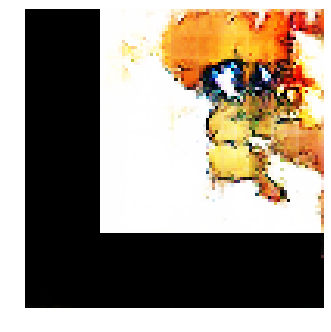


Epoch: 33860, D: -7.209, G: 3.605
Epoch: 33861, D: -5.376, G: 3.466
Epoch: 33862, D: -6.646, G: 4.311
Epoch: 33863, D: -5.719, G: 2.374
Epoch: 33864, D: -6.822, G: 3.404
Epoch: 33865, D: -7.143, G: 1.443
Epoch: 33866, D: -5.74, G: 2.826
Epoch: 33867, D: -6.051, G: 2.751
Epoch: 33868, D: -5.125, G: 3.44
Epoch: 33869, D: -6.297, G: 3.992
Epoch: 33870, D: -6.617, G: 2.407
Epoch: 33871, D: -6.055, G: 4.202
Epoch: 33872, D: -4.705, G: 2.555
Epoch: 33873, D: -6.477, G: 3.121
Epoch: 33874, D: -6.842, G: 1.919
Epoch: 33875, D: -6.325, G: 4.701
Epoch: 33876, D: -5.313, G: 3.101
Epoch: 33877, D: -5.688, G: 2.943
Epoch: 33878, D: -6.183, G: 2.891
Epoch: 33879, D: -6.38, G: 2.19


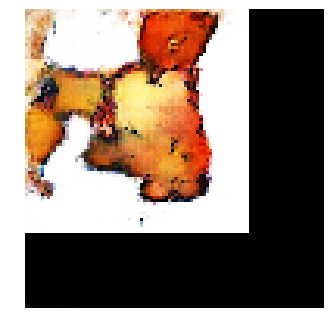


Epoch: 33880, D: -5.065, G: 4.178
Epoch: 33881, D: -5.818, G: 2.849
Epoch: 33882, D: -6.454, G: 4.382
Epoch: 33883, D: -5.176, G: 3.391
Epoch: 33884, D: -5.285, G: 5.668
Epoch: 33885, D: -8.15, G: 4.615
Epoch: 33886, D: -5.588, G: 3.565
Epoch: 33887, D: -5.23, G: 4.046
Epoch: 33888, D: -6.404, G: 3.402
Epoch: 33889, D: -5.138, G: 5.603
Epoch: 33890, D: -5.285, G: 3.359
Epoch: 33891, D: -4.604, G: 3.871
Epoch: 33892, D: -4.545, G: 4.578
Epoch: 33893, D: -6.962, G: 4.151
Epoch: 33894, D: -6.753, G: 3.552
Epoch: 33895, D: -6.544, G: 4.031
Epoch: 33896, D: -5.631, G: 4.405
Epoch: 33897, D: -6.379, G: 4.103
Epoch: 33898, D: -7.407, G: 4.346
Epoch: 33899, D: -5.541, G: 4.108


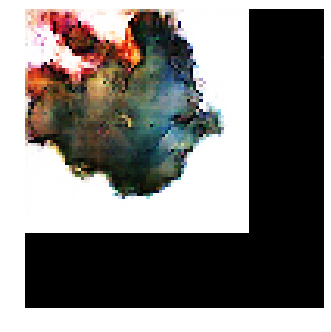


Epoch: 33900, D: -6.25, G: 4.075
Epoch: 33901, D: -6.495, G: 5.959
Epoch: 33902, D: -5.223, G: 4.17
Epoch: 33903, D: -6.885, G: 4.569
Epoch: 33904, D: -5.512, G: 4.591
Epoch: 33905, D: -5.614, G: 4.666
Epoch: 33906, D: -7.035, G: 3.82
Epoch: 33907, D: -6.577, G: 6.277
Epoch: 33908, D: -6.72, G: 3.824
Epoch: 33909, D: -5.874, G: 2.743
Epoch: 33910, D: -6.296, G: 4.992
Epoch: 33911, D: -5.646, G: 2.931
Epoch: 33912, D: -5.37, G: 3.035
Epoch: 33913, D: -6.608, G: 2.799
Epoch: 33914, D: -6.935, G: 1.99
Epoch: 33915, D: -5.153, G: 2.308
Epoch: 33916, D: -5.855, G: 2.92
Epoch: 33917, D: -5.601, G: 3.498
Epoch: 33918, D: -4.457, G: 4.173
Epoch: 33919, D: -5.504, G: 2.134


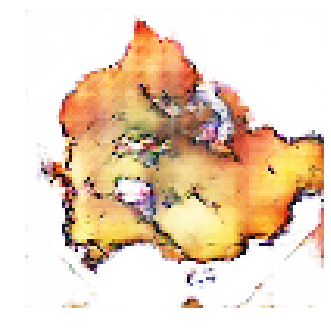


Epoch: 33920, D: -5.088, G: 3.05
Epoch: 33921, D: -5.644, G: 2.101
Epoch: 33922, D: -5.005, G: 5.293
Epoch: 33923, D: -7.912, G: 3.782
Epoch: 33924, D: -7.147, G: 3.297
Epoch: 33925, D: -6.645, G: 4.111
Epoch: 33926, D: -6.122, G: 3.617
Epoch: 33927, D: -4.799, G: 5.111
Epoch: 33928, D: -6.573, G: 5.624
Epoch: 33929, D: -5.11, G: 5.313
Epoch: 33930, D: -5.822, G: 3.935
Epoch: 33931, D: -6.551, G: 1.4
Epoch: 33932, D: -7.051, G: 3.662
Epoch: 33933, D: -4.742, G: 2.984
Epoch: 33934, D: -6.172, G: 3.586
Epoch: 33935, D: -6.059, G: 4.748
Epoch: 33936, D: -6.861, G: 6.713
Epoch: 33937, D: -6.569, G: 3.377
Epoch: 33938, D: -5.531, G: 2.954
Epoch: 33939, D: -6.45, G: 3.889


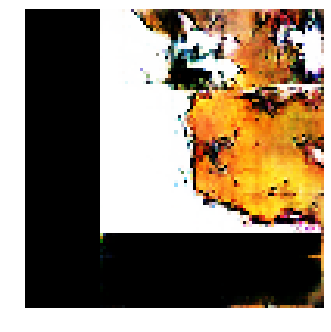


Epoch: 33940, D: -6.687, G: 4.028
Epoch: 33941, D: -5.649, G: 5.11
Epoch: 33942, D: -5.832, G: 2.887
Epoch: 33943, D: -6.029, G: 5.033
Epoch: 33944, D: -7.165, G: 3.77
Epoch: 33945, D: -5.774, G: 4.65
Epoch: 33946, D: -6.072, G: 3.352
Epoch: 33947, D: -5.645, G: 4.032
Epoch: 33948, D: -6.055, G: 2.397
Epoch: 33949, D: -6.556, G: 2.452
Epoch: 33950, D: -5.125, G: 3.276
Epoch: 33951, D: -6.374, G: 4.337
Epoch: 33952, D: -6.417, G: 5.18
Epoch: 33953, D: -6.735, G: 2.968
Epoch: 33954, D: -7.136, G: 3.076
Epoch: 33955, D: -7.741, G: 3.293
Epoch: 33956, D: -5.248, G: 2.894
Epoch: 33957, D: -6.438, G: 3.292
Epoch: 33958, D: -5.214, G: 3.064
Epoch: 33959, D: -6.403, G: 3.951


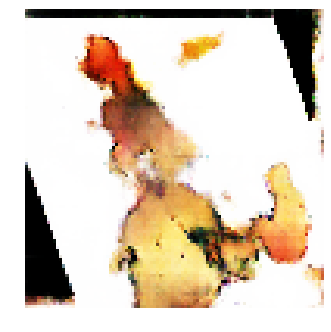


Epoch: 33960, D: -5.76, G: 3.509
Epoch: 33961, D: -6.118, G: 3.442
Epoch: 33962, D: -6.413, G: 4.659
Epoch: 33963, D: -5.573, G: 4.009
Epoch: 33964, D: -5.264, G: 5.305
Epoch: 33965, D: -6.416, G: 4.323
Epoch: 33966, D: -6.295, G: 4.521
Epoch: 33967, D: -6.067, G: 4.557
Epoch: 33968, D: -6.268, G: 2.422
Epoch: 33969, D: -5.389, G: 2.704
Epoch: 33970, D: -6.832, G: 4.248
Epoch: 33971, D: -5.1, G: 3.634
Epoch: 33972, D: -5.278, G: 2.257
Epoch: 33973, D: -5.099, G: 5.697
Epoch: 33974, D: -4.906, G: 4.432
Epoch: 33975, D: -5.626, G: 3.178
Epoch: 33976, D: -4.976, G: 3.685
Epoch: 33977, D: -5.901, G: 3.261
Epoch: 33978, D: -7.193, G: 3.253
Epoch: 33979, D: -5.807, G: 3.73


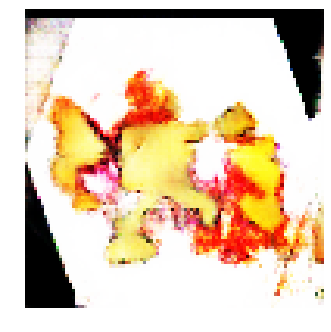


Epoch: 33980, D: -6.447, G: 2.61
Epoch: 33981, D: -6.272, G: 3.413
Epoch: 33982, D: -5.951, G: 3.197
Epoch: 33983, D: -6.916, G: 3.425
Epoch: 33984, D: -6.203, G: 4.002
Epoch: 33985, D: -5.807, G: 4.129
Epoch: 33986, D: -5.369, G: 4.372
Epoch: 33987, D: -5.899, G: 3.591
Epoch: 33988, D: -7.229, G: 3.316
Epoch: 33989, D: -6.239, G: 3.47
Epoch: 33990, D: -6.301, G: 4.044
Epoch: 33991, D: -6.848, G: 3.716
Epoch: 33992, D: -6.695, G: 5.408
Epoch: 33993, D: -6.427, G: 4.651
Epoch: 33994, D: -5.123, G: 3.449
Epoch: 33995, D: -6.757, G: 3.615
Epoch: 33996, D: -6.987, G: 3.102
Epoch: 33997, D: -5.498, G: 2.943
Epoch: 33998, D: -6.618, G: 3.121
Epoch: 33999, D: -5.674, G: 3.458


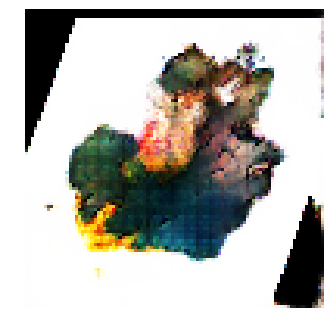


Epoch: 34000, D: -6.541, G: 2.925
Epoch: 34001, D: -5.437, G: 5.121
Epoch: 34002, D: -5.939, G: 4.17
Epoch: 34003, D: -8.167, G: 4.345
Epoch: 34004, D: -5.627, G: 4.564
Epoch: 34005, D: -6.759, G: 4.397
Epoch: 34006, D: -5.884, G: 3.284
Epoch: 34007, D: -5.378, G: 4.749
Epoch: 34008, D: -7.054, G: 3.248
Epoch: 34009, D: -5.526, G: 3.252
Epoch: 34010, D: -5.668, G: 2.65
Epoch: 34011, D: -5.967, G: 4.942
Epoch: 34012, D: -7.244, G: 4.985
Epoch: 34013, D: -6.871, G: 3.495
Epoch: 34014, D: -4.966, G: 3.275
Epoch: 34015, D: -5.783, G: 4.122
Epoch: 34016, D: -6.071, G: 4.685
Epoch: 34017, D: -6.801, G: 4.93
Epoch: 34018, D: -5.96, G: 5.229
Epoch: 34019, D: -5.904, G: 3.449


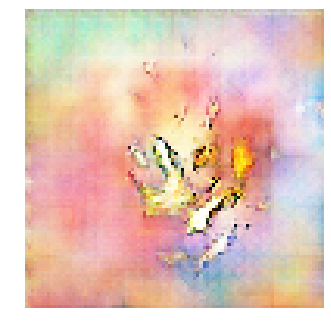


Epoch: 34020, D: -4.33, G: 4.407
Epoch: 34021, D: -6.465, G: 4.716
Epoch: 34022, D: -8.412, G: 5.014
Epoch: 34023, D: -7.129, G: 2.335
Epoch: 34024, D: -7.918, G: 4.065
Epoch: 34025, D: -7.239, G: 3.488
Epoch: 34026, D: -5.816, G: 2.978
Epoch: 34027, D: -7.997, G: 3.258
Epoch: 34028, D: -6.229, G: 4.388
Epoch: 34029, D: -5.912, G: 4.612
Epoch: 34030, D: -6.997, G: 3.261
Epoch: 34031, D: -6.279, G: 3.512
Epoch: 34032, D: -4.434, G: 3.383
Epoch: 34033, D: -5.482, G: 5.374
Epoch: 34034, D: -6.124, G: 2.73
Epoch: 34035, D: -5.718, G: 5.119
Epoch: 34036, D: -6.176, G: 3.274
Epoch: 34037, D: -6.371, G: 4.758
Epoch: 34038, D: -5.555, G: 2.869
Epoch: 34039, D: -6.748, G: 4.508


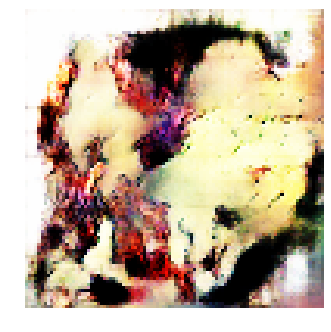


Epoch: 34040, D: -5.775, G: 2.047
Epoch: 34041, D: -6.62, G: 5.569
Epoch: 34042, D: -6.72, G: 4.351
Epoch: 34043, D: -6.214, G: 4.016
Epoch: 34044, D: -5.443, G: 4.097
Epoch: 34045, D: -6.236, G: 4.081
Epoch: 34046, D: -5.999, G: 4.272
Epoch: 34047, D: -6.681, G: 4.639
Epoch: 34048, D: -6.358, G: 3.817
Epoch: 34049, D: -5.331, G: 3.248
Epoch: 34050, D: -5.644, G: 3.71
Epoch: 34051, D: -5.281, G: 3.99
Epoch: 34052, D: -4.893, G: 3.155
Epoch: 34053, D: -6.483, G: 4.79
Epoch: 34054, D: -6.758, G: 3.488
Epoch: 34055, D: -6.364, G: 3.673
Epoch: 34056, D: -6.091, G: 2.734
Epoch: 34057, D: -6.625, G: 5.26
Epoch: 34058, D: -5.633, G: 4.406
Epoch: 34059, D: -5.966, G: 4.555


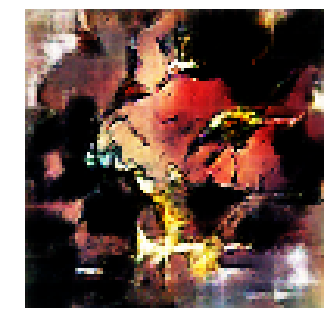


Epoch: 34060, D: -5.962, G: 2.901
Epoch: 34061, D: -6.771, G: 2.396
Epoch: 34062, D: -7.609, G: 2.976
Epoch: 34063, D: -6.178, G: 2.887
Epoch: 34064, D: -6.25, G: 2.851
Epoch: 34065, D: -4.9, G: 3.199
Epoch: 34066, D: -4.691, G: 3.357
Epoch: 34067, D: -5.921, G: 3.318
Epoch: 34068, D: -6.348, G: 3.649
Epoch: 34069, D: -6.486, G: 3.327
Epoch: 34070, D: -4.705, G: 2.689
Epoch: 34071, D: -6.952, G: 3.951
Epoch: 34072, D: -5.521, G: 3.268
Epoch: 34073, D: -6.105, G: 4.265
Epoch: 34074, D: -5.644, G: 4.438
Epoch: 34075, D: -6.243, G: 3.707
Epoch: 34076, D: -6.275, G: 2.85
Epoch: 34077, D: -5.547, G: 3.491
Epoch: 34078, D: -6.204, G: 3.508
Epoch: 34079, D: -5.074, G: 3.679


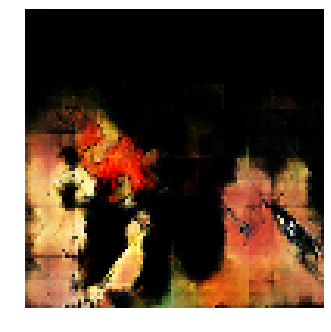


Epoch: 34080, D: -5.986, G: 3.167
Epoch: 34081, D: -6.211, G: 5.266
Epoch: 34082, D: -3.884, G: 5.456
Epoch: 34083, D: -5.251, G: 2.665
Epoch: 34084, D: -6.776, G: 2.505
Epoch: 34085, D: -6.567, G: 5.363
Epoch: 34086, D: -6.844, G: 3.101
Epoch: 34087, D: -6.619, G: 2.846
Epoch: 34088, D: -4.388, G: 3.481
Epoch: 34089, D: -6.501, G: 2.827
Epoch: 34090, D: -5.901, G: 3.335
Epoch: 34091, D: -7.331, G: 2.514
Epoch: 34092, D: -6.609, G: 3.613
Epoch: 34093, D: -6.249, G: 3.94
Epoch: 34094, D: -4.605, G: 4.063
Epoch: 34095, D: -6.576, G: 6.64
Epoch: 34096, D: -6.39, G: 3.198
Epoch: 34097, D: -7.47, G: 4.027
Epoch: 34098, D: -6.016, G: 5.911
Epoch: 34099, D: -5.004, G: 4.782


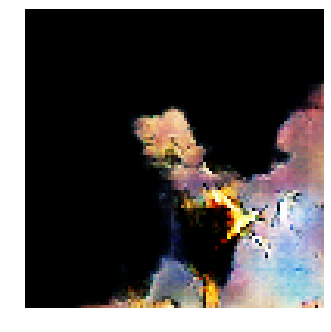


Epoch: 34100, D: -6.569, G: 4.088
Epoch: 34101, D: -6.093, G: 3.189
Epoch: 34102, D: -5.684, G: 3.002
Epoch: 34103, D: -6.494, G: 4.799
Epoch: 34104, D: -5.285, G: 5.148
Epoch: 34105, D: -7.141, G: 4.224
Epoch: 34106, D: -5.752, G: 2.472
Epoch: 34107, D: -7.224, G: 3.806
Epoch: 34108, D: -5.133, G: 3.641
Epoch: 34109, D: -6.081, G: 4.319
Epoch: 34110, D: -5.615, G: 4.201
Epoch: 34111, D: -7.771, G: 4.579
Epoch: 34112, D: -6.308, G: 4.345
Epoch: 34113, D: -5.147, G: 4.419
Epoch: 34114, D: -7.12, G: 3.601
Epoch: 34115, D: -4.958, G: 3.565
Epoch: 34116, D: -5.583, G: 4.68
Epoch: 34117, D: -5.795, G: 3.224
Epoch: 34118, D: -5.048, G: 5.791
Epoch: 34119, D: -7.496, G: 5.261


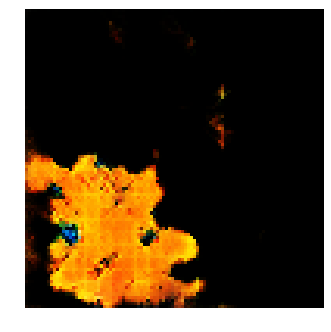


Epoch: 34120, D: -5.979, G: 3.671
Epoch: 34121, D: -8.054, G: 4.752
Epoch: 34122, D: -6.025, G: 3.379
Epoch: 34123, D: -7.6, G: 4.144
Epoch: 34124, D: -5.875, G: 4.201
Epoch: 34125, D: -5.604, G: 5.297
Epoch: 34126, D: -6.854, G: 3.962
Epoch: 34127, D: -5.934, G: 4.588
Epoch: 34128, D: -6.115, G: 4.189
Epoch: 34129, D: -6.148, G: 3.028
Epoch: 34130, D: -5.994, G: 3.985
Epoch: 34131, D: -5.111, G: 2.822
Epoch: 34132, D: -5.048, G: 3.838
Epoch: 34133, D: -6.322, G: 2.485
Epoch: 34134, D: -5.094, G: 3.364
Epoch: 34135, D: -4.45, G: 2.967
Epoch: 34136, D: -6.47, G: 2.494
Epoch: 34137, D: -5.855, G: 2.085
Epoch: 34138, D: -6.152, G: 4.134
Epoch: 34139, D: -6.899, G: 5.5


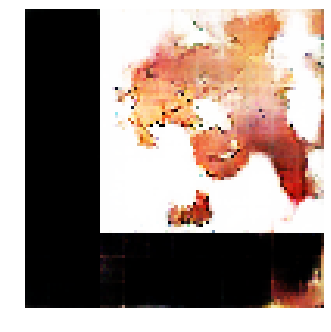


Epoch: 34140, D: -6.161, G: 5.187
Epoch: 34141, D: -5.179, G: 4.872
Epoch: 34142, D: -5.447, G: 3.724
Epoch: 34143, D: -6.97, G: 4.137
Epoch: 34144, D: -5.826, G: 3.697
Epoch: 34145, D: -5.489, G: 3.914
Epoch: 34146, D: -5.853, G: 4.0
Epoch: 34147, D: -5.381, G: 2.507
Epoch: 34148, D: -5.62, G: 4.485
Epoch: 34149, D: -5.413, G: 2.778
Epoch: 34150, D: -5.476, G: 5.54
Epoch: 34151, D: -6.134, G: 4.082
Epoch: 34152, D: -7.732, G: 5.109
Epoch: 34153, D: -6.252, G: 3.426
Epoch: 34154, D: -6.239, G: 4.047
Epoch: 34155, D: -6.58, G: 6.227
Epoch: 34156, D: -5.077, G: 4.215
Epoch: 34157, D: -6.605, G: 4.436
Epoch: 34158, D: -5.759, G: 4.428
Epoch: 34159, D: -7.061, G: 2.911


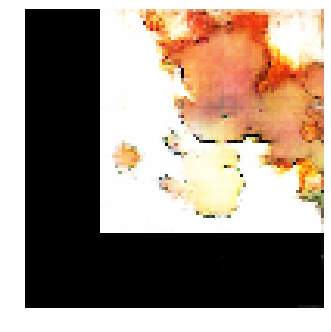


Epoch: 34160, D: -6.98, G: 2.63
Epoch: 34161, D: -6.497, G: 4.129
Epoch: 34162, D: -5.571, G: 4.517
Epoch: 34163, D: -8.327, G: 6.016
Epoch: 34164, D: -6.577, G: 4.637
Epoch: 34165, D: -5.636, G: 2.457
Epoch: 34166, D: -5.805, G: 3.344
Epoch: 34167, D: -6.64, G: 4.029
Epoch: 34168, D: -6.456, G: 5.063
Epoch: 34169, D: -7.596, G: 3.775
Epoch: 34170, D: -5.83, G: 5.109
Epoch: 34171, D: -6.373, G: 3.501
Epoch: 34172, D: -6.541, G: 4.325
Epoch: 34173, D: -6.008, G: 2.811
Epoch: 34174, D: -4.962, G: 3.255
Epoch: 34175, D: -5.654, G: 2.116
Epoch: 34176, D: -4.673, G: 3.21
Epoch: 34177, D: -5.591, G: 3.848
Epoch: 34178, D: -4.791, G: 3.541
Epoch: 34179, D: -7.194, G: 3.499


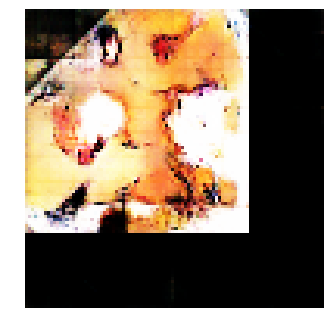


Epoch: 34180, D: -6.069, G: 3.032
Epoch: 34181, D: -6.997, G: 5.663
Epoch: 34182, D: -6.869, G: 3.503
Epoch: 34183, D: -5.977, G: 2.854
Epoch: 34184, D: -6.844, G: 3.852
Epoch: 34185, D: -5.841, G: 3.227
Epoch: 34186, D: -6.956, G: 3.748
Epoch: 34187, D: -5.138, G: 1.446
Epoch: 34188, D: -4.787, G: 3.212
Epoch: 34189, D: -5.852, G: 3.759
Epoch: 34190, D: -6.343, G: 3.276
Epoch: 34191, D: -5.632, G: 2.815
Epoch: 34192, D: -6.49, G: 3.875
Epoch: 34193, D: -6.074, G: 3.381
Epoch: 34194, D: -6.358, G: 3.118
Epoch: 34195, D: -5.764, G: 4.134
Epoch: 34196, D: -7.616, G: 4.381
Epoch: 34197, D: -5.485, G: 3.526
Epoch: 34198, D: -7.029, G: 3.489
Epoch: 34199, D: -5.817, G: 2.041


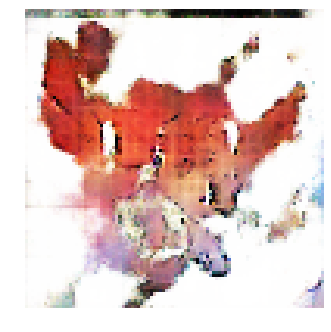


Epoch: 34200, D: -5.398, G: 3.364
Epoch: 34201, D: -6.47, G: 5.106
Epoch: 34202, D: -5.616, G: 3.718
Epoch: 34203, D: -5.445, G: 2.363
Epoch: 34204, D: -7.582, G: 5.049
Epoch: 34205, D: -6.351, G: 3.086
Epoch: 34206, D: -5.929, G: 4.447
Epoch: 34207, D: -5.378, G: 4.943
Epoch: 34208, D: -5.785, G: 6.075
Epoch: 34209, D: -7.027, G: 2.95
Epoch: 34210, D: -6.424, G: 2.353
Epoch: 34211, D: -4.756, G: 2.982
Epoch: 34212, D: -6.227, G: 4.652
Epoch: 34213, D: -6.884, G: 2.925
Epoch: 34214, D: -6.012, G: 3.647
Epoch: 34215, D: -5.838, G: 2.578
Epoch: 34216, D: -5.895, G: 3.624
Epoch: 34217, D: -5.51, G: 3.29
Epoch: 34218, D: -6.048, G: 4.124
Epoch: 34219, D: -6.76, G: 3.423


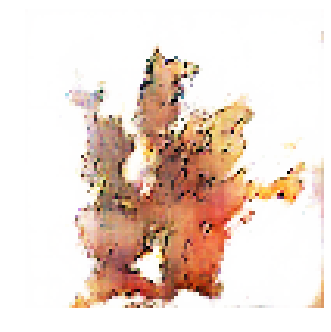


Epoch: 34220, D: -6.109, G: 2.29
Epoch: 34221, D: -6.991, G: 3.502
Epoch: 34222, D: -6.079, G: 3.814
Epoch: 34223, D: -5.716, G: 4.437
Epoch: 34224, D: -5.625, G: 3.246
Epoch: 34225, D: -6.306, G: 5.128
Epoch: 34226, D: -6.643, G: 5.625
Epoch: 34227, D: -5.751, G: 4.511
Epoch: 34228, D: -6.932, G: 4.67
Epoch: 34229, D: -7.083, G: 3.882
Epoch: 34230, D: -5.643, G: 4.545
Epoch: 34231, D: -5.132, G: 6.173
Epoch: 34232, D: -5.948, G: 4.636
Epoch: 34233, D: -5.485, G: 2.416
Epoch: 34234, D: -7.711, G: 3.384
Epoch: 34235, D: -6.933, G: 2.772
Epoch: 34236, D: -4.739, G: 3.07
Epoch: 34237, D: -4.452, G: 4.299
Epoch: 34238, D: -6.324, G: 4.377
Epoch: 34239, D: -6.662, G: 5.349


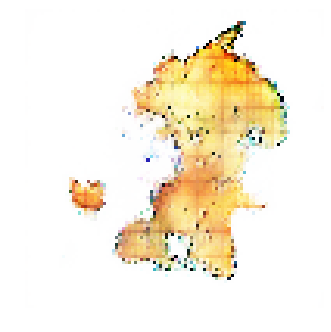


Epoch: 34240, D: -6.135, G: 3.487
Epoch: 34241, D: -6.708, G: 5.141
Epoch: 34242, D: -4.882, G: 3.268
Epoch: 34243, D: -5.506, G: 2.964
Epoch: 34244, D: -6.797, G: 2.906
Epoch: 34245, D: -7.177, G: 1.966
Epoch: 34246, D: -6.005, G: 3.611
Epoch: 34247, D: -5.176, G: 4.14
Epoch: 34248, D: -6.19, G: 4.052
Epoch: 34249, D: -6.82, G: 4.22
Epoch: 34250, D: -7.007, G: 2.308
Epoch: 34251, D: -6.059, G: 4.747
Epoch: 34252, D: -5.001, G: 2.662
Epoch: 34253, D: -6.227, G: 2.866
Epoch: 34254, D: -6.141, G: 2.28
Epoch: 34255, D: -8.594, G: 2.952
Epoch: 34256, D: -5.169, G: 3.638
Epoch: 34257, D: -6.508, G: 2.992
Epoch: 34258, D: -6.226, G: 2.976
Epoch: 34259, D: -5.011, G: 1.182


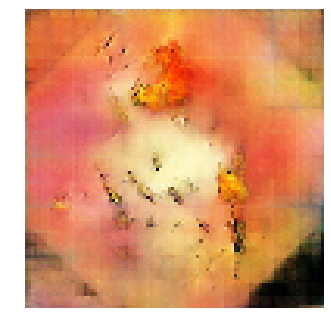


Epoch: 34260, D: -5.78, G: 3.844
Epoch: 34261, D: -7.089, G: 3.863
Epoch: 34262, D: -6.455, G: 4.379
Epoch: 34263, D: -6.739, G: 4.427
Epoch: 34264, D: -7.083, G: 3.133
Epoch: 34265, D: -5.936, G: 2.016
Epoch: 34266, D: -6.422, G: 0.186
Epoch: 34267, D: -7.514, G: 1.612
Epoch: 34268, D: -6.033, G: 3.816
Epoch: 34269, D: -5.086, G: 3.222
Epoch: 34270, D: -6.272, G: 3.509
Epoch: 34271, D: -7.637, G: 4.159
Epoch: 34272, D: -5.519, G: 3.71
Epoch: 34273, D: -6.971, G: 3.769
Epoch: 34274, D: -5.344, G: 3.326
Epoch: 34275, D: -6.217, G: 2.381
Epoch: 34276, D: -8.468, G: 5.3
Epoch: 34277, D: -5.884, G: 3.726
Epoch: 34278, D: -5.809, G: 2.779
Epoch: 34279, D: -5.867, G: 4.553


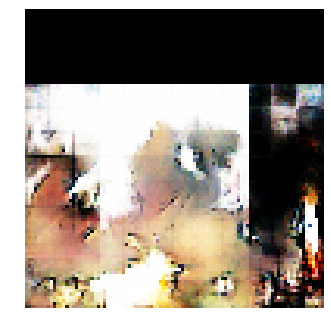


Epoch: 34280, D: -5.633, G: 4.132
Epoch: 34281, D: -6.391, G: 2.499
Epoch: 34282, D: -6.33, G: 3.917
Epoch: 34283, D: -5.578, G: 3.942
Epoch: 34284, D: -6.486, G: 1.606
Epoch: 34285, D: -5.528, G: 5.004
Epoch: 34286, D: -6.455, G: 4.001
Epoch: 34287, D: -6.132, G: 3.909
Epoch: 34288, D: -7.04, G: 4.529
Epoch: 34289, D: -6.856, G: 4.939
Epoch: 34290, D: -5.767, G: 5.566
Epoch: 34291, D: -7.0, G: 4.683
Epoch: 34292, D: -6.843, G: 4.055
Epoch: 34293, D: -5.638, G: 4.763
Epoch: 34294, D: -6.264, G: 3.819
Epoch: 34295, D: -4.663, G: 3.965
Epoch: 34296, D: -6.354, G: 3.326
Epoch: 34297, D: -6.525, G: 3.982
Epoch: 34298, D: -5.646, G: 3.799
Epoch: 34299, D: -5.313, G: 3.905


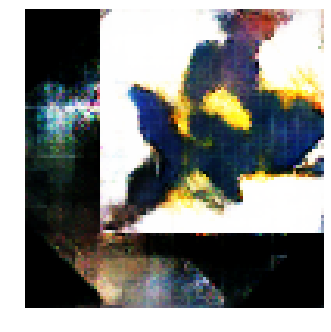


Epoch: 34300, D: -6.943, G: 3.227
Epoch: 34301, D: -5.666, G: 2.604
Epoch: 34302, D: -5.569, G: 2.414
Epoch: 34303, D: -5.392, G: 2.617
Epoch: 34304, D: -6.207, G: 5.245
Epoch: 34305, D: -6.006, G: 2.604
Epoch: 34306, D: -6.945, G: 1.935
Epoch: 34307, D: -7.176, G: 4.967
Epoch: 34308, D: -7.137, G: 2.646
Epoch: 34309, D: -6.589, G: 3.482
Epoch: 34310, D: -5.408, G: 5.376
Epoch: 34311, D: -6.685, G: 4.608
Epoch: 34312, D: -5.224, G: 4.819
Epoch: 34313, D: -5.473, G: 3.983
Epoch: 34314, D: -7.64, G: 3.576
Epoch: 34315, D: -6.08, G: 3.515
Epoch: 34316, D: -5.36, G: 2.66
Epoch: 34317, D: -5.297, G: 2.844
Epoch: 34318, D: -5.393, G: 4.553
Epoch: 34319, D: -6.907, G: 3.052


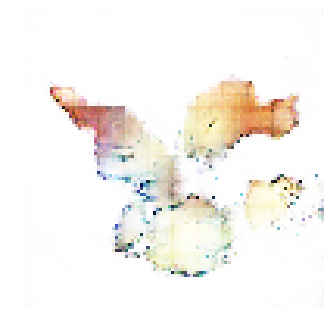


Epoch: 34320, D: -5.637, G: 4.589
Epoch: 34321, D: -6.842, G: 4.135
Epoch: 34322, D: -5.613, G: 2.357
Epoch: 34323, D: -5.458, G: 4.743
Epoch: 34324, D: -7.088, G: 4.423
Epoch: 34325, D: -7.223, G: 4.182
Epoch: 34326, D: -7.379, G: 4.733
Epoch: 34327, D: -6.552, G: 4.145
Epoch: 34328, D: -5.75, G: 3.879
Epoch: 34329, D: -5.751, G: 3.175
Epoch: 34330, D: -6.579, G: 2.563
Epoch: 34331, D: -6.175, G: 4.046
Epoch: 34332, D: -6.132, G: 4.539
Epoch: 34333, D: -6.061, G: 3.872
Epoch: 34334, D: -7.499, G: 2.962
Epoch: 34335, D: -5.924, G: 2.595
Epoch: 34336, D: -6.12, G: 2.688
Epoch: 34337, D: -5.557, G: 4.506
Epoch: 34338, D: -4.513, G: 2.953
Epoch: 34339, D: -5.702, G: 3.621


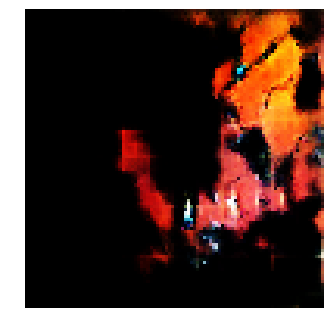


Epoch: 34340, D: -6.827, G: 4.849
Epoch: 34341, D: -4.993, G: 3.575
Epoch: 34342, D: -7.978, G: 5.22
Epoch: 34343, D: -7.27, G: 2.623
Epoch: 34344, D: -7.635, G: 6.324
Epoch: 34345, D: -5.964, G: 4.342
Epoch: 34346, D: -5.474, G: 3.661
Epoch: 34347, D: -6.244, G: 4.389
Epoch: 34348, D: -5.215, G: 6.114
Epoch: 34349, D: -5.908, G: 2.46
Epoch: 34350, D: -5.629, G: 4.207
Epoch: 34351, D: -6.464, G: 5.055
Epoch: 34352, D: -7.016, G: 4.223
Epoch: 34353, D: -5.922, G: 2.738
Epoch: 34354, D: -8.376, G: 5.776
Epoch: 34355, D: -7.295, G: 5.309
Epoch: 34356, D: -6.696, G: 4.453
Epoch: 34357, D: -6.178, G: 5.311
Epoch: 34358, D: -6.411, G: 5.223
Epoch: 34359, D: -4.946, G: 3.463


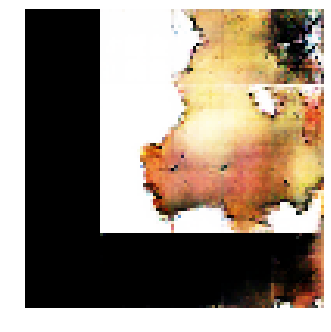


Epoch: 34360, D: -5.396, G: 3.744
Epoch: 34361, D: -4.56, G: 4.469
Epoch: 34362, D: -7.003, G: 3.156
Epoch: 34363, D: -6.567, G: 2.594
Epoch: 34364, D: -6.81, G: 4.107
Epoch: 34365, D: -6.115, G: 1.759
Epoch: 34366, D: -6.938, G: 3.666
Epoch: 34367, D: -5.435, G: 4.027
Epoch: 34368, D: -5.557, G: 4.09
Epoch: 34369, D: -5.649, G: 4.723
Epoch: 34370, D: -5.41, G: 4.126
Epoch: 34371, D: -6.212, G: 3.343
Epoch: 34372, D: -7.344, G: 3.03
Epoch: 34373, D: -4.84, G: 1.741
Epoch: 34374, D: -6.593, G: 2.224
Epoch: 34375, D: -5.415, G: 1.114
Epoch: 34376, D: -7.179, G: 4.356
Epoch: 34377, D: -6.872, G: 4.383
Epoch: 34378, D: -5.928, G: 4.46
Epoch: 34379, D: -6.289, G: 1.727


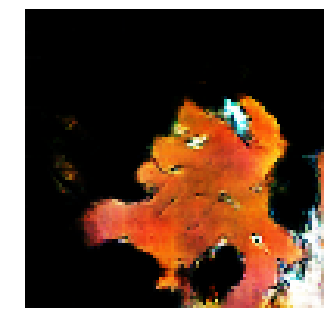


Epoch: 34380, D: -7.138, G: 4.519
Epoch: 34381, D: -7.072, G: 3.287
Epoch: 34382, D: -5.147, G: 4.049
Epoch: 34383, D: -6.594, G: 5.371
Epoch: 34384, D: -8.079, G: 2.973
Epoch: 34385, D: -5.672, G: 2.806
Epoch: 34386, D: -5.917, G: 3.45
Epoch: 34387, D: -6.15, G: 3.378
Epoch: 34388, D: -7.282, G: 5.833
Epoch: 34389, D: -6.333, G: 5.106
Epoch: 34390, D: -6.952, G: 7.588
Epoch: 34391, D: -6.169, G: 4.201
Epoch: 34392, D: -4.948, G: 3.389
Epoch: 34393, D: -5.155, G: 3.943
Epoch: 34394, D: -6.063, G: 4.179
Epoch: 34395, D: -6.956, G: 3.439
Epoch: 34396, D: -6.259, G: 6.584
Epoch: 34397, D: -7.11, G: 2.027
Epoch: 34398, D: -6.843, G: 1.695
Epoch: 34399, D: -6.269, G: 1.904


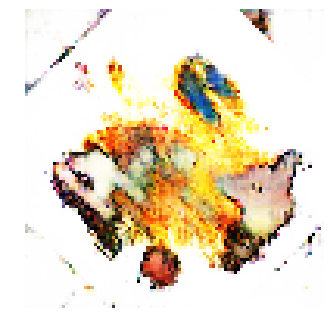


Epoch: 34400, D: -6.445, G: 3.68
Epoch: 34401, D: -7.56, G: 3.168
Epoch: 34402, D: -7.616, G: 4.093
Epoch: 34403, D: -6.082, G: 4.302
Epoch: 34404, D: -6.088, G: 5.062
Epoch: 34405, D: -4.967, G: 3.645
Epoch: 34406, D: -6.866, G: 4.361
Epoch: 34407, D: -7.22, G: 3.34
Epoch: 34408, D: -7.005, G: 5.408
Epoch: 34409, D: -6.833, G: 3.77
Epoch: 34410, D: -6.107, G: 2.905
Epoch: 34411, D: -7.419, G: 4.015
Epoch: 34412, D: -7.669, G: 4.829
Epoch: 34413, D: -5.826, G: 5.136
Epoch: 34414, D: -5.935, G: 4.059
Epoch: 34415, D: -6.516, G: 4.056
Epoch: 34416, D: -5.747, G: 3.273
Epoch: 34417, D: -6.498, G: 4.154
Epoch: 34418, D: -5.664, G: 3.255
Epoch: 34419, D: -6.338, G: 2.33


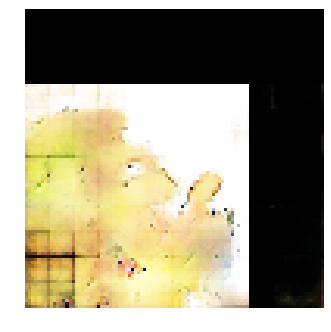


Epoch: 34420, D: -5.693, G: 3.367
Epoch: 34421, D: -5.858, G: 3.468
Epoch: 34422, D: -5.654, G: 3.284
Epoch: 34423, D: -6.876, G: 2.894
Epoch: 34424, D: -5.602, G: 3.733
Epoch: 34425, D: -6.434, G: 3.745
Epoch: 34426, D: -6.976, G: 3.802
Epoch: 34427, D: -5.763, G: 1.919
Epoch: 34428, D: -6.212, G: 4.072
Epoch: 34429, D: -6.989, G: 5.104
Epoch: 34430, D: -6.56, G: 2.544
Epoch: 34431, D: -6.954, G: 4.553
Epoch: 34432, D: -6.693, G: 3.312
Epoch: 34433, D: -5.752, G: 3.391
Epoch: 34434, D: -5.801, G: 2.873
Epoch: 34435, D: -6.105, G: 3.281
Epoch: 34436, D: -6.993, G: 4.813
Epoch: 34437, D: -4.797, G: 4.688
Epoch: 34438, D: -7.31, G: 3.821
Epoch: 34439, D: -4.648, G: 3.951


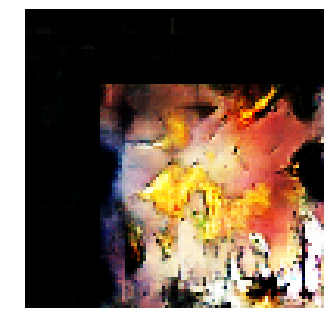


Epoch: 34440, D: -5.631, G: 3.718
Epoch: 34441, D: -5.813, G: 5.297
Epoch: 34442, D: -4.189, G: 4.785
Epoch: 34443, D: -5.974, G: 5.089
Epoch: 34444, D: -7.721, G: 4.365
Epoch: 34445, D: -5.768, G: 3.555
Epoch: 34446, D: -6.72, G: 3.569
Epoch: 34447, D: -5.733, G: 3.671
Epoch: 34448, D: -6.467, G: 4.748
Epoch: 34449, D: -8.18, G: 4.042
Epoch: 34450, D: -5.701, G: 3.527
Epoch: 34451, D: -6.302, G: 3.816
Epoch: 34452, D: -6.687, G: 5.116
Epoch: 34453, D: -4.381, G: 3.034
Epoch: 34454, D: -6.328, G: 5.085
Epoch: 34455, D: -6.969, G: 3.873
Epoch: 34456, D: -5.6, G: 5.033
Epoch: 34457, D: -6.692, G: 4.004
Epoch: 34458, D: -6.946, G: 1.256
Epoch: 34459, D: -5.685, G: 2.795


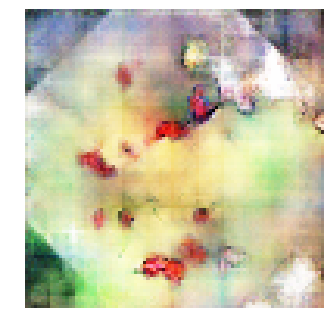


Epoch: 34460, D: -4.641, G: 5.824
Epoch: 34461, D: -7.177, G: 3.484
Epoch: 34462, D: -5.514, G: 4.061


In [0]:
#with tf.Session() as sess:
sess = tf.Session()
saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())
#print('Initialization done!')


#Test saving and loading
#save_path = saver.save(sess, 'drive/Pokemon/Checkpoints/model.ckpt')
ckpt = tf.train.latest_checkpoint('drive/Pokemon_Fire/Final_Checkpoints')
print(ckpt)
saver.restore(sess,ckpt)
print('Restored!')

run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,saver,num_epoch=15000)
 
save_inputs ={"isTrain":isTrain}
save_outputs = {"generator/generator_out":G_sample}

tf.saved_model.simple_save(sess, 'drive/Pokemon_Fire/Saved_model_Final',save_inputs,save_outputs)

In [0]:
save_inputs ={"isTrain":isTrain}
save_outputs = {"generator/generator_out":G_sample}

tf.saved_model.simple_save(sess, 'drive/Pokemon/Saved_modelGP',save_inputs,save_outputs)

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.4 GB  | Proc size: 5.2 GB
GPU RAM Free: 503MB | Used: 10936MB | Util  96% | Total 11439MB


In [0]:
!ps ax | grep python

   82 ?        Sl     0:10 /usr/bin/python2 /usr/local/bin/jupyter-notebook -y --no-browser --log-level=DEBUG --debug --NotebookApp.allow_origin="*" --NotebookApp.log_format="%(message)s" --NotebookApp.disable_check_xsrf=True --NotebookApp.token= --Session.key="" --Session.keyfile="" --ContentsManager.untitled_directory="Untitled Folder" --ContentsManager.untitled_file="Untitled File" --ContentsManager.untitled_notebook="Untitled Notebook" --KernelManager.autorestart=True --MultiKernelManager.default_kernel_name="python2" --ip="172.28.0.2" --port=9000 --port-retries=0 --notebook-dir="/content" --NotebookApp.base_url=/tun/m/gpu-1oh0mpcgklgqc/
   90 ?        Ssl  223:25 /usr/bin/python3 -m ipykernel_launcher -f /content/.local/share/jupyter/runtime/kernel-14d934e3-be51-46ed-9bdb-cf6fa1f8fa07.json
24021 ?        Ssl    0:10 /usr/bin/python3 -m ipykernel_launcher -f /content/.local/share/jupyter/runtime/kernel-bd5eb725-93eb-4089-b928-3dc6365a54c7.json
30723 pts/0    Ss+    0:00 /bin/sh -c 

In [0]:
!kill -9 90

In [0]:
#Clear everything
!kill -9 -1

In [0]:
sess.close()